In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [2]:
def load_and_merge_data():
    kamis = pd.read_csv('kamis_maize_prices.csv')
    agri1 = pd.read_csv('agriBORA_maize_prices.csv')
    agri2 = pd.read_csv('agriBORA_maize_prices_weeks_46_to_51.csv')

    kamis = kamis[kamis['Commodity_Classification'] == 'Dry_White_Maize']
    kamis = kamis[['Date', 'County', 'Wholesale']].rename(columns={'Wholesale': 'Price'})
    agri = pd.concat([agri1, agri2])
    agri = agri[['Date', 'County', 'WholeSale']].rename(columns={'WholeSale': 'Price'})


    df = pd.concat([kamis, agri])
    df['Date'] = pd.to_datetime(df['Date'])
    

    df_weekly = df.groupby(['County', pd.Grouper(key='Date', freq='W')]).mean().reset_index()
    return df_weekly

df_all = load_and_merge_data()
display(df_all.head())
display(df_all.info())
display(df_all.describe())
print(df_all['County'].value_counts())

,County,Date,Price
0,Baringo,2021-05-30,27.309808
1,Baringo,2021-06-06,30.000000
2,Baringo,2021-06-13,26.780000
3,Baringo,2021-06-20,27.390000
4,Baringo,2021-06-27,29.260000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   County  4837 non-null   object        
 1   Date    4837 non-null   datetime64[ns]
 2   Price   4763 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 113.5+ KB


None

,Date,Price
count,4837,4763.000000
mean,2023-01-20 16:38:12.329956352,50.260855
min,2021-05-30 00:00:00,10.000000
25%,2022-03-20 00:00:00,35.560000
50%,2022-12-04 00:00:00,49.165000
75%,2023-09-10 00:00:00,63.404722
max,2025-12-21 00:00:00,261.110000
std,NaN,16.416358


County
Uasin-Gishu        213
Nairobi            201
Kirinyaga          193
Kisumu             184
Migori             171
Nandi              170
Nakuru             166
Meru               166
Bomet              160
Siaya              157
Kitui              154
Trans-Nzoia        153
Vihiga             140
Nyeri              139
Nyamira            129
Embu               126
Busia              124
Kakamega           120
Makueni            119
Tharaka-Nithi      119
Bungoma            117
Baringo            115
Kisii              112
Kajiado            112
West-Pokot         111
Homa-Bay           102
Nyandarua          101
Kericho             98
Taita-Taveta        97
Elgeyo-Marakwet     91
Mandera             90
Garissa             77
Laikipia            73
Kiambu              68
Machakos            65
Mombasa             64
Muranga             52
Narok               49
Turkana             37
Tana-River          27
Kilifi              23
Isiolo              21
Kwale               15
Samb

In [3]:
def create_features(df):
    df = df.sort_values(['County', 'Date'])
    
    #lags
    for i in range(1, 5):
        df[f'lag_price_{i}'] = df.groupby('County')['Price'].shift(i)
    
    #rolling means
    df['rolling_mean_4'] = df.groupby('County')['Price'].transform(lambda x: x.rolling(window=4).mean())
    
    #month
    df['month'] = df['Date'].dt.month
    
    # un sans NaN et un avec
    df_with_nans = df.copy()
    df_cleaned = df.dropna()
    
    return df_with_nans, df_cleaned

df_preview, data_ready = create_features(df_all)


print("Zoom sur les Lags")
display(df_preview[df_preview['County'] == 'Nairobi'].head(8))

print(f"\nNombre de lignes après avoir supprimé NaNs: {data_ready.shape[0]}")

Zoom sur les Lags


,County,Date,Price,lag_price_1,lag_price_2,lag_price_3,lag_price_4,rolling_mean_4,month
2816,Nairobi,2021-05-30,31.49,NaN,NaN,NaN,NaN,NaN,5
2817,Nairobi,2021-06-20,27.78,31.49,NaN,NaN,NaN,NaN,6
2818,Nairobi,2021-07-04,45.00,27.78,31.49,NaN,NaN,NaN,7
2819,Nairobi,2021-07-11,NaN,45.00,27.78,31.49,NaN,NaN,7
2820,Nairobi,2021-07-25,40.00,NaN,45.00,27.78,31.49,NaN,7
2821,Nairobi,2021-08-01,NaN,40.00,NaN,45.00,27.78,NaN,8
2822,Nairobi,2021-08-08,35.00,NaN,40.00,NaN,45.00,NaN,8
2823,Nairobi,2021-08-15,NaN,35.00,NaN,40.00,NaN,NaN,8



Nombre de lignes après avoir supprimé NaNs: 4461


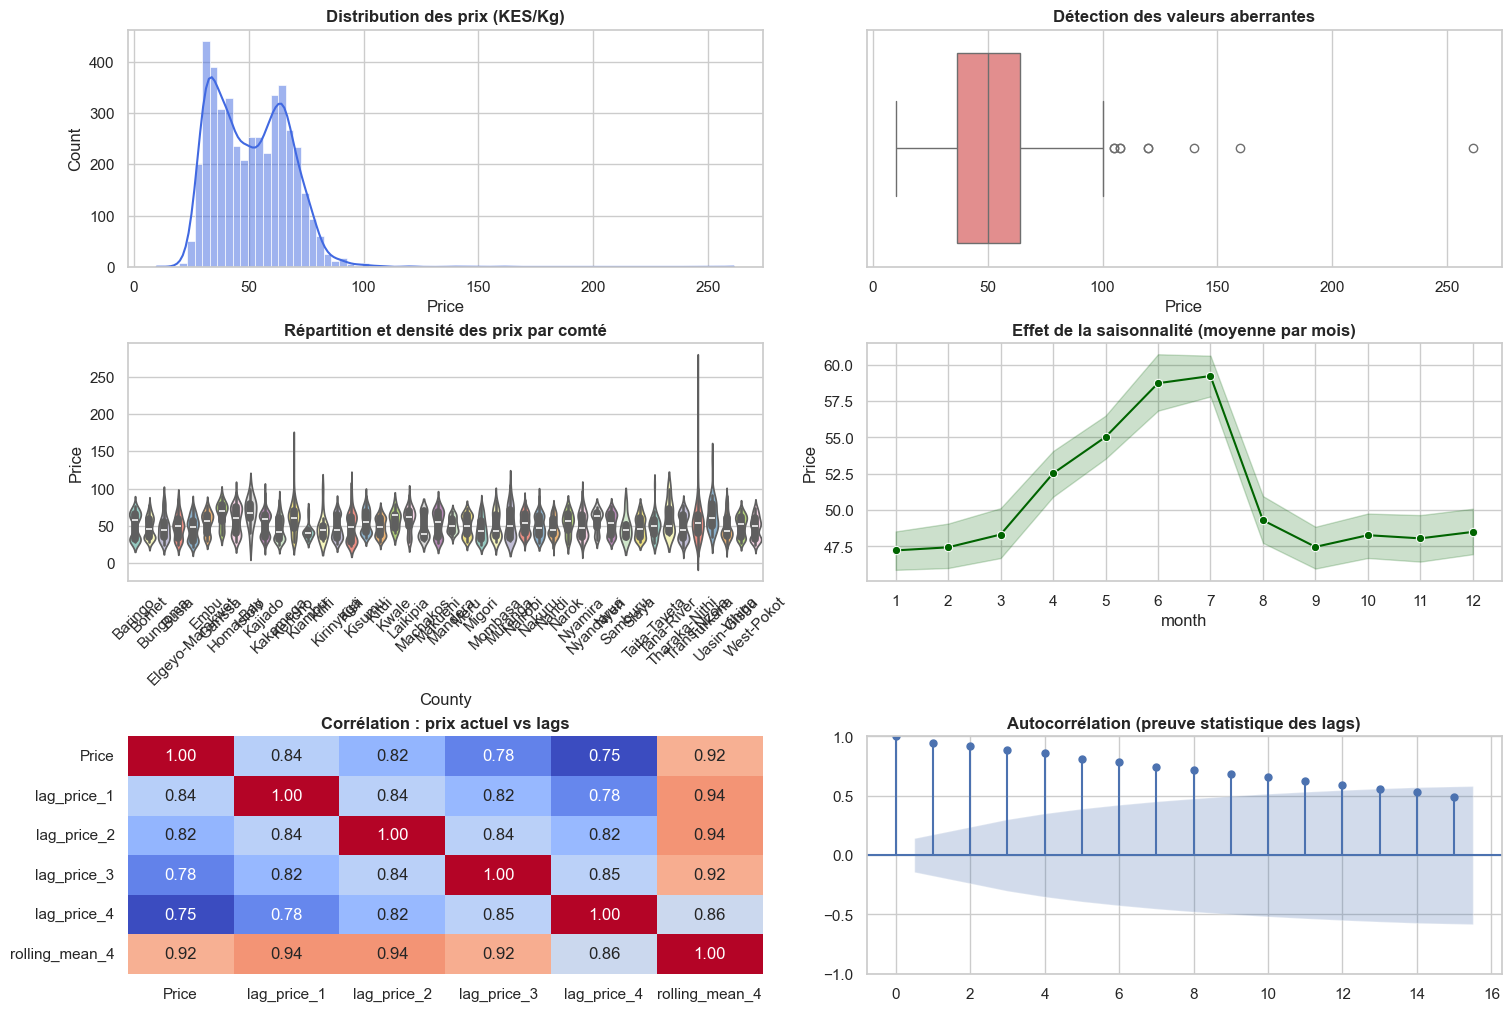

In [4]:
plt.rcParams['figure.figsize'] = (15, 10)
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

#uni
ax1 = fig.add_subplot(spec[0, 0])
sns.histplot(data_ready['Price'], kde=True, color='royalblue', ax=ax1)
ax1.set_title("Distribution des prix (KES/Kg)", fontweight='bold')

#bi
ax2 = fig.add_subplot(spec[0, 1])
sns.boxplot(x=data_ready['Price'], color='lightcoral', ax=ax2)
ax2.set_title("Détection des valeurs aberrantes", fontweight='bold')

#multi
ax3 = fig.add_subplot(spec[1, 0])
sns.violinplot(x='County', y='Price', data=data_ready, palette='Set3', ax=ax3)
ax3.set_title("Répartition et densité des prix par comté", fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

#saisonnalité mensuelle
ax4 = fig.add_subplot(spec[1, 1])
sns.lineplot(x='month', y='Price', data=data_ready, marker='o', color='darkgreen', ax=ax4)
ax4.set_title("Effet de la saisonnalité (moyenne par mois)", fontweight='bold')
ax4.set_xticks(range(1, 13))

#corrélation
ax5 = fig.add_subplot(spec[2, 0])
cols = ['Price', 'lag_price_1', 'lag_price_2', 'lag_price_3', 'lag_price_4', 'rolling_mean_4']
corr = data_ready[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax5, cbar=False)
ax5.set_title("Corrélation : prix actuel vs lags", fontweight='bold')

#autocorrélation
ax6 = fig.add_subplot(spec[2, 1])
plot_acf(data_ready[data_ready['County'] == 'Nairobi']['Price'], lags=15, ax=ax6)
ax6.set_title("Autocorrélation (preuve statistique des lags)", fontweight='bold')

plt.show()

In [5]:
data_model = pd.get_dummies(data_ready, columns=['County'])
X = data_model.drop(['Date', 'Price'], axis=1)
y = data_model['Price']


split = int(len(data_model) * 0.9)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


joblib.dump(model, 'model.pkl')
joblib.dump(X_train.columns.tolist(), 'features.pkl')

['features.pkl']

In [6]:
display(data_model.head())

,Date,Price,lag_price_1,lag_price_2,lag_price_3,lag_price_4,rolling_mean_4,month,County_Baringo,County_Bomet,...,County_Samburu,County_Siaya,County_Taita-Taveta,County_Tana-River,County_Tharaka-Nithi,County_Trans-Nzoia,County_Turkana,County_Uasin-Gishu,County_Vihiga,County_West-Pokot
4,2021-06-27,29.260,27.390,26.780,30.00,27.309808,28.35750,6,True,False,...,False,False,False,False,False,False,False,False,False,False
5,2021-07-04,29.260,29.260,27.390,26.78,30.000000,28.17250,7,True,False,...,False,False,False,False,False,False,False,False,False,False
6,2021-07-11,29.445,29.260,29.260,27.39,26.780000,28.83875,7,True,False,...,False,False,False,False,False,False,False,False,False,False
7,2021-07-18,28.885,29.445,29.260,29.26,27.390000,29.21250,7,True,False,...,False,False,False,False,False,False,False,False,False,False
8,2021-07-25,32.590,28.885,29.445,29.26,29.260000,30.04500,7,True,False,...,False,False,False,False,False,False,False,False,False,False


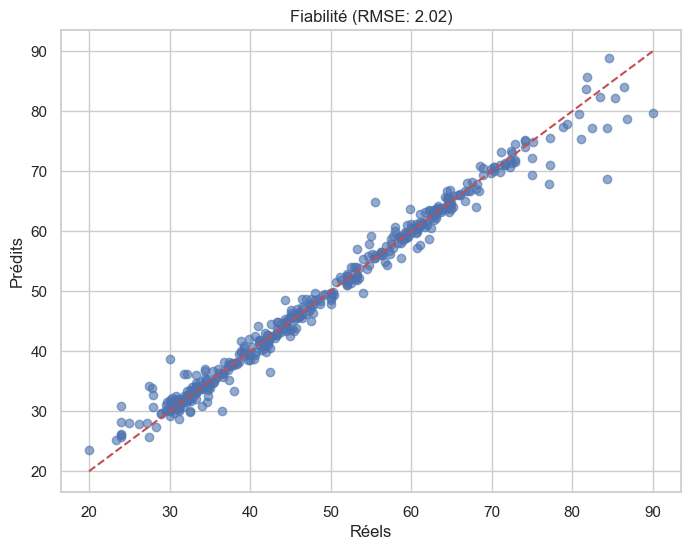

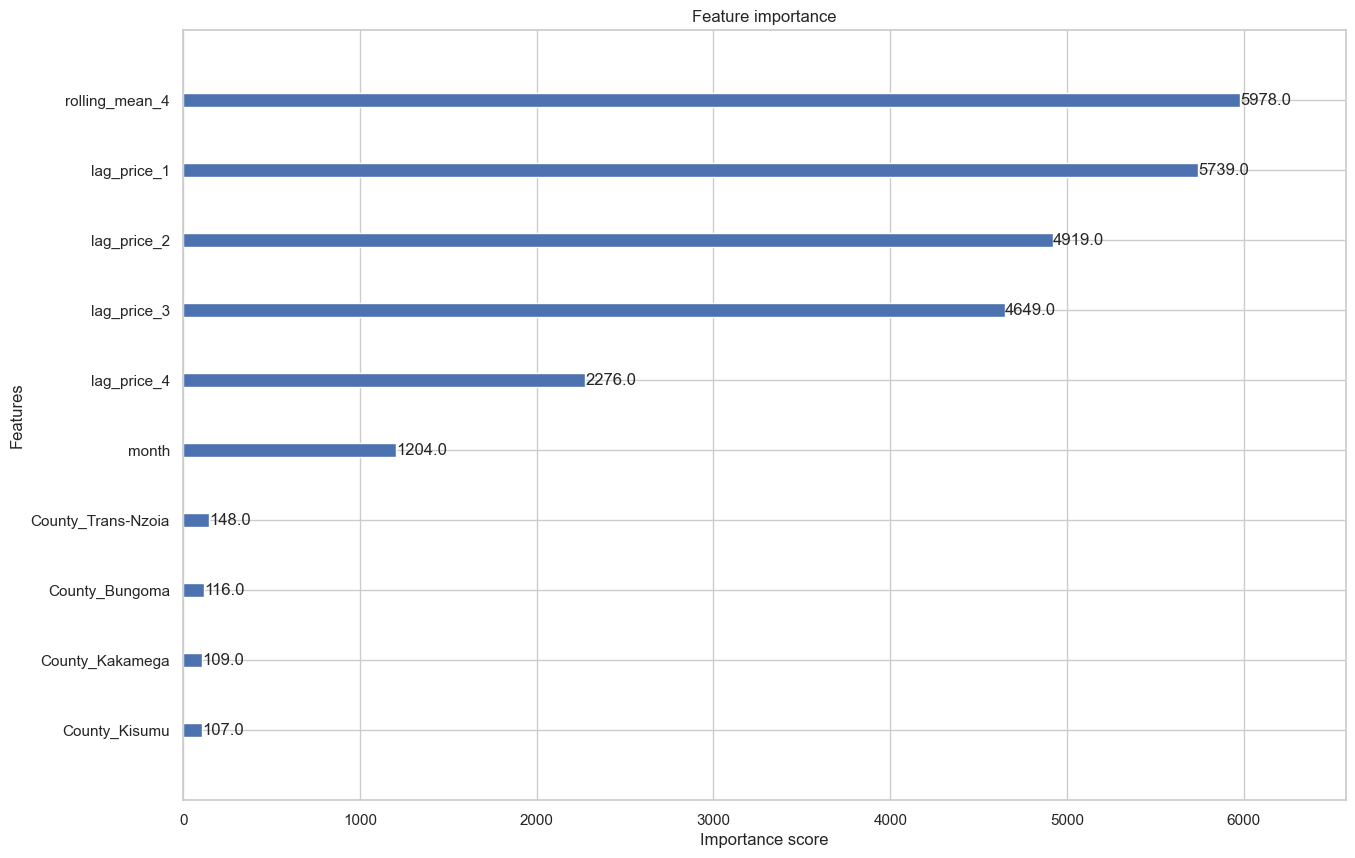

In [7]:
y_pred = model.predict(X_test)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Réels")
plt.ylabel("Prédits")
plt.title(f"Fiabilité (RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f})")
plt.show()


xgb.plot_importance(model, max_num_features=10)
plt.show()

In [8]:
target_counties = ['Kiambu', 'Kirinyaga', 'Mombasa', 'Nairobi', 'Uasin-Gishu']
submission = pd.read_csv('SampleSubmission.csv')

for county in target_counties:
    last_row = data_ready[data_ready['County'] == county].tail(1)
    if not last_row.empty:
        input_data = pd.get_dummies(last_row, columns=['County'])
        input_data = input_data.reindex(columns=X_train.columns, fill_value=0)
        pred = model.predict(input_data)[0]
        submission.loc[submission['ID'].str.contains(county), 'Target_RMSE'] = pred
        submission.loc[submission['ID'].str.contains(county), 'Target_MAE'] = pred

submission.to_csv('submission.csv', index=False)

ARIMA - MAE: 1.34
ARIMA - RMSE: 2.74


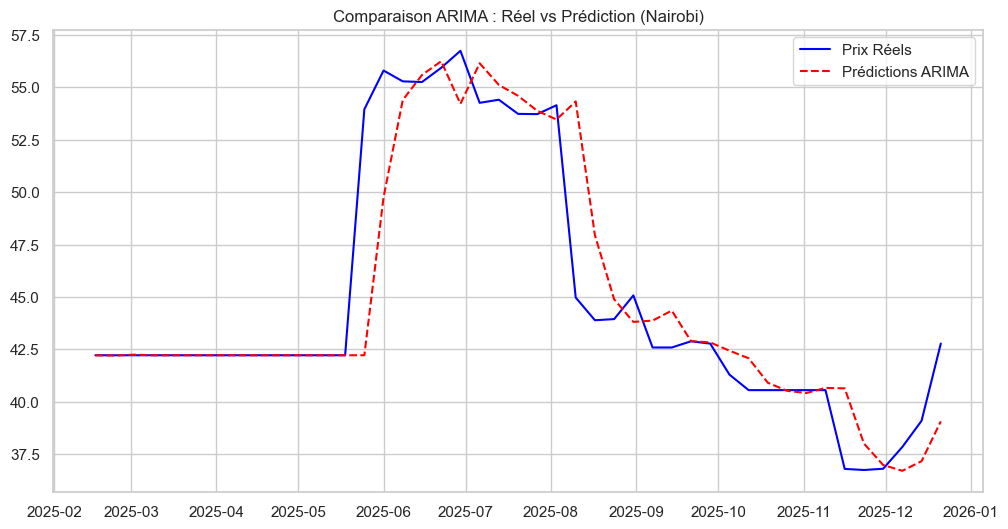

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


df_nairobi = data_ready[data_ready['County'] == 'Nairobi'].set_index('Date')['Price']
df_nairobi = df_nairobi.asfreq('W').fillna(method='ffill') # Assure une fréquence hebdomadaire
train_size = int(len(df_nairobi) * 0.8)
train, test = df_nairobi[0:train_size], df_nairobi[train_size:]

#train arima
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

#pred
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])

mae_arima = mean_absolute_error(test, predictions)
rmse_arima = np.sqrt(mean_squared_error(test, predictions))

print(f"ARIMA - MAE: {mae_arima:.2f}")
print(f"ARIMA - RMSE: {rmse_arima:.2f}")


plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Prix Réels', color='blue')
plt.plot(test.index, predictions, label='Prédictions ARIMA', color='red', linestyle='--')
plt.title('Comparaison ARIMA : Réel vs Prédiction (Nairobi)')
plt.legend()
plt.show()